In [1]:
import faiss 
import sys
import os
import math
import random
import heapq 
import time
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO,BytesIO 
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
from functools import reduce

Loading faiss with AVX2 support.


In [2]:
# SIFT extracting
def sift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    _,des = sift.detectAndCompute(gray,None) 

    return des

imgDes = []
imgDict = {}
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
nums = 0
for itype in ['AMD','DR','glaucoma','myopia','norm']: #AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
    image_dir = root_dir+'img_data_%s'%itype
    for fname in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, fname)
        if fname.endswith(".jpg"):
            try:
                des = sift_extractor(image_path)
                imgDes.extend(des)
                imgDict[itype+"|"+fname] = des
            except:
                print(fname+":"+str(image_path))
        nums = nums +1
        sys.stdout.write('\r{} / {} '.format(nums,10000))
        sys.stdout.flush()
imgDes = np.array(imgDes).astype('float32') #must be float32

10000 / 10000 

In [3]:
#cluster the sift features

#firstly, bulid the index
#dimensions = 128 #default dimension of keypoints
#tstart = time.time()
#cpu_index = faiss.IndexFlatL2(dimensions) #construct index
#gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
#gpu_index.add (imgDes)
#elapsed = time.time() - tstart    
#print('Completed buliding index in %d seconds' % int(elapsed))
#cpu_index = faiss.index_gpu_to_cpu(gpu_index) #for search 

#second, cluster the description
dimensions = 128
ncentroids = 1024
tstart = time.time()
kmeans = faiss.Kmeans(dimensions, ncentroids, niter=20, verbose=True)
kmeans.train(imgDes)
elapsed = time.time() - tstart    
print('Completed Training Kmeans in %d seconds' % int(elapsed))

Completed Training Kmeans in 2 seconds


In [13]:
#construct relevance matrix
imgCen = []
imgKey = []
for key, value in imgDict.items():
    D, I = kmeans.index.search(value, 1)
    imgKey.append([key.split('|')[0], key.split('|')[1], len(imgCen)])
    imgCen.append( np.bincount(I.flatten(), minlength=ncentroids).tolist())

imgMat = np.zeros([len(imgCen), len(imgCen)], dtype=np.float32)
for i in range(len(imgCen)):
    for j in range(len(imgCen)):
        imgMat[i][j] = float(np.sum(np.logical_and(imgCen[i],imgCen[j]))/ncentroids)
imgKey = np.array(imgKey)
#np.savetxt("/data/tmpexec/iSee_rel.txt", imgMat, fmt="%s",delimiter=",")
#np.savetxt("/data/tmpexec/iSee_map.txt", imgKey, fmt="%s",delimiter=",")

KeyboardInterrupt: 

In [70]:
#imgMat = np.loadtxt("/data/tmpexec/iSee_rel.txt",delimiter=",")
#imgKey = np.loadtxt("/data/tmpexec/iSee_map.txt",delimiter=",")
#check dataset
def value_count(arr):
    arr = np.array(arr)
    key = np.unique(arr)
    result = {}
    for k in key:
        mask = (arr == k)
        arr_new = arr[mask]
        v = arr_new.size
        result[k] = v
    return result
print (value_count(imgCen[0]))

{0: 912, 1: 85, 2: 17, 3: 8, 4: 2}


In [107]:
imgTest = []
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    if itype=='AMD': num=72
    elif itype=='DR': num=27
    elif itype=='glaucoma': num=45
    elif itype=='myopia': num=79
    else: num =777
    imgTest.extend(random.sample(imgKey[imgKey[:,0]==itype].tolist(),num))
for topk in [5,10,15]:
    HR =[] #Hit Ratio 
    AP =[] #Average Precision
    for stype, sname, snum in imgTest:
        #rank = np.argsort(imgMat[int(snum)]).tolist()
        #rank = np.array(rank.remove(str(snum)))#remove self
        rank = np.argsort(imgMat[int(snum)])
        #perfromance
        pos_len = 0
        rank_len = 0
        print (rank.tolist()[-topk])
        print (rank.tolist()[topk])
        break
        for j in rank.tolist()[-topk]: #reverse order
            dtype, dname, dnum = (imgKey[imgKey[:,2]==str(j)]).flatten()
            assert int(dnum)==int(j)
            rank_len=rank_len+1
            if stype==dtype:  #hit
                HR.append(1)
                pos_len = pos_len +1
                AP.append(pos_len/rank_len) 
            else: 
                HR.append(0)
                AP.append(0)   
    print("HR@{}={:.6f}, AP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(AP)))

HR@5=0.285449, MAP@5=0.242188
HR@10=0.281424, MAP@10=0.230779
HR@15=0.278844, MAP@15=0.225076


In [17]:
#bulid index
imgWF = [] #record features
imgName = [] #record name and type
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
#AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    image_dir = root_dir+'img_data_%s'%itype
    for fname in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, fname)
        if fname.endswith(".jpg"):
            try:
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (64, 64))#resize image 1920x1942
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
                    cA, (cH, cV, cD) = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
                    imgWF.append(cA.flatten())
                    #imgSign = avhash(image_path)#pha algorithm
                    imgName.append([fname, itype])
            except:
                print(fname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(imgWF),10000))
        sys.stdout.flush()
imgWF = np.array(imgWF).astype('float32') #must be float32
imgName = np.array(imgName)
tstart = time.time()
dimensions = 32*32
cpu_index = faiss.IndexFlatL2(dimensions) #construct index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(imgWF) #add data to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

10000 / 10000 Completed buliding index in 173 seconds


In [53]:
imgTest = []
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    if itype=='AMD': num=72
    elif itype=='DR': num=27
    elif itype=='glaucoma': num=45
    elif itype=='myopia': num=79
    else: num =100
    imgTest.extend(random.sample(imgName[imgName[:,1]==itype].tolist(),num))
               
for topk in [5,10,15]:
    HR =[] #Hit ratio 
    MAP =[] #mean average precision
    for sname, stype in imgTest:
        i = np.argwhere( (imgName[:,0]==sname) & (imgName[:,1]==stype) ).flatten()[0]
        scores, neighbors = gpu_index.search(imgWF[i:i+1], k=topk+1)
        #perfromance
        pos_len = 0
        rank_len = 0
        for j in neighbors.flatten()[1:]:#remove self
            dname, dtype = imgName[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                HR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
            else: 
                HR.append(0)
                MAP.append(0)   
    print("HR@{}={:.6f}, MAP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP)))      

HR@5=0.319505, MAP@5=0.272683
HR@10=0.312074, MAP@10=0.248811
HR@15=0.311042, MAP@15=0.241258


In [52]:
sname, stype = imgTest[0]
print (sname+":"+stype)
i = np.argwhere( (imgName[:,0]==sname) & (imgName[:,1]==stype) ).flatten()[0]
scores, neighbors = gpu_index.search(imgWF[i:i+1], k=5+1)
for j in neighbors.flatten()[1:]:
    dname, dtype = imgName[j]
    if (sname != dname) and (stype!=itype):
        print (dname+":"+dtype)

82835.jpg:AMD
98119.jpg:DR
83450.jpg:norm
912201.jpg:norm
914251.jpg:norm
82354.jpg:norm


91
35


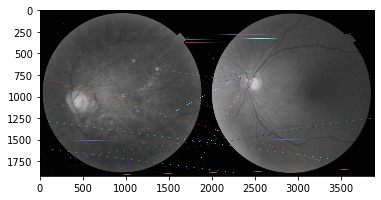

In [12]:
import cv2 
import matplotlib.pyplot as plt

# read images
img1 = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/99699.jpg')  
img2 = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/99602.jpg') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

print (len(keypoints_1))
print (len(keypoints_2))

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3)
plt.show()

[[<DMatch 0x7febac035b90>]
 [<DMatch 0x7feb941068d0>]
 [<DMatch 0x7feb94106910>]
 [<DMatch 0x7feb94106950>]
 [<DMatch 0x7feb94106990>]
 [<DMatch 0x7feb941069d0>]
 [<DMatch 0x7feb94106b50>]
 [<DMatch 0x7feb94106b90>]
 [<DMatch 0x7feb94106bd0>]]


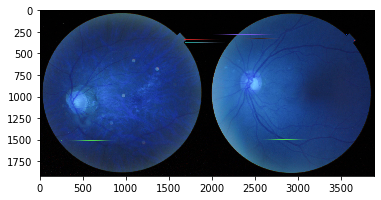

In [17]:
import cv2 
import matplotlib.pyplot as plt

# read images
img1 = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/99699.jpg')  
img2 = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/99602.jpg') 
# 3) SIFT特征计算
sift = cv2.xfeatures2d.SIFT_create()

psd_kp1, psd_des1 = sift.detectAndCompute(img1, None)
psd_kp2, psd_des2 = sift.detectAndCompute(img2, None)

# 4) Flann特征匹配
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(psd_des1, psd_des2, k=2)
goodMatch = []
for m, n in matches:
    # goodMatch是经过筛选的优质配对，如果2个配对中第一匹配的距离小于第二匹配的距离的1/2，基本可以说明这个第一配对是两幅图像中独特的，不重复的特征点,可以保留。
    if m.distance < 0.50*n.distance:
        goodMatch.append(m)
# 增加一个维度
goodMatch = np.expand_dims(goodMatch, 1)
print(goodMatch[:20])

img_out = cv2.drawMatchesKnn(img1, psd_kp1, img2, psd_kp2, goodMatch[:15], None, flags=2)

plt.imshow(img_out)#展示图片